<a href="https://colab.research.google.com/github/taliafabs/sta365-winter2025/blob/main/sta365hw10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STA365 Homework 10
Week 12, April 2, 2024

In [48]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from scipy.special import softmax
import arviz as az
import pytensor

## Question 1

Define:
- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

Resources used:

*   https://scikit-learn.org/stable/modules/gaussian_process.html
*   STA414 lecture materials https://erdogdu.github.io/sta414/slides/w12/sld12-1.pdf




**Gaussian processes**
- Gaussian processes (GPs) are non-parametric supervised ML methods used for both regression and probabilistic classification.
- A Gaussian process is a probability distribution over functions $ŷ(\textbf{x})$, where for any $N≥1$ and points $\textbf{x}^{(1)}...\textbf{x}^{(n)} \in \mathbb{R}^D$, vector $\left(ŷ(\textbf{x}^{(1)}) ... ŷ(\textbf{x}^{(n)}) \right)^\top$ is jointly gaussian. ([STA414 Lecture 12](https://erdogdu.github.io/sta414/slides/w12/sld12-1.pdf))
- We can often et the meean function to zero to make the Gaussian process specifiable by the covariance function ([STA414 Lecture 12](https://erdogdu.github.io/sta414/slides/w12/sld12-1.pdf)).

**Stochastic processes**
- Stochastic processes are collections of random variables indexed by time (or another param), used to model how a system subject to *randomness* changes.
- For example, gradient descent can be implemented as a stochastic process if the gradient computed using a randomly selected mini-batch (with a size of at least 1 but smaller than the full batch) every iteration; stochastic process bc the updates depend on the randomly sampled data point(s) (aka the minibatch), changes over time $t$
- Stochastic variational inference (SVI) is the stochastic process implementation of variational inference. Instead of computing the full gradient (not plausible to do), a simple monte carlo estimate of the gradient is computed each iteration and a minibatch is used ([STA414](https://erdogdu.github.io/sta414/slides/w09/sld09.pdf)).



**Variational inference using the Evidence Lower Bound (ELBO)**
- Variational inference is a process for approximating a complicated posterior, $p(z|x)$ that we don't really have access to. We start by choosing tractable parametric distrtibution $q_\phi(z)$, and use some sort of "distance" to quantify how good or "close" an approximator $q_\phi(z)$ is for $p(z|x)$ ([STA414](https://erdogdu.github.io/sta414/slides/w09/sld09.pdf)). Minimizing it becomes our "objective."
- $KL(q_\phi(z) || p(z|x)$ is intractable because $\int p(z|x) dz$ is implausible and way too compex for us to compute, so we maximize the evidence lower bound (ELBO) instead.
- Maximizing the ELBO is the same thing as minimizing $KL(q_\phi(z) || p(z|x)$, so it is a good objective for variational inference. We use the reparameterization trick to make the densiy independent of $\phi$ and allow us to use simple monte carlo.
- All in all, maximizing the ELBO (and doing the reparameterization trick and monte carlo) is a way to achieve a good variational inference approximation without dealing with the intractabl, overly complicated, and extremely difficult to work with posterior!

Why maximizing ELBO is equivalent to minimizing $KL(q_\phi(z) || p(z|x)$:
\begin{align*}
    \text{KL}(q_\phi(z) \parallel p(z|x)) &= \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{q_\phi(z)}{p(z|x)} \right] \\
    &= \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{q_\phi(z) p(x)}{p(z, x)} \right] \\
    &= \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{q_\phi(z)}{p(z, x)} \right] + \mathbb{E}_{z \sim q_\phi} \left[ \log p(x) \right] \\
    &:= -L(\phi) + \log p(x) = - \text{ELBO} + \log p(x)
\end{align*}

Where $-L(\phi)$ is the ELBO:
\begin{align*}
L(\phi) = \mathbb{E}_{z \sim q_\phi} \left[ \log p(z, x) - \log q_\phi(z) \right]
\end{align*}

## Question 2

More Gaussian Processes

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

Resource used: https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Latent.html

Note: Running a process analogous to the pymc examples kept crashing google colab, jupyterhub, and when i ran it locally on my computer in vscode. I had to ask ChatGPT how to modify it so that the computational load would be reduced. I also had to significantly reduce my sample size.

In [3]:
# california housing dataset (good bc it has continuous target)
rng = np.random.default_rng(365)

from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
data = pd.DataFrame(data.data, columns=data.feature_names).dropna()
X = data['AveRooms'].values.reshape(-1, 1) # averooms as input
y = data['MedInc']

# normalize
scaler = StandardScaler()
X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

# reducing sample size so it can actually run
X = X[np.random.choice(len(X), size=200, replace=False)]
y = y[np.random.choice(len(y), size=200, replace=False)]

In [82]:
# california housing dataset (good bc it has continuous target)
rng = np.random.default_rng(365)

from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
data = pd.DataFrame(data.data, columns=data.feature_names).dropna()
X = data['AveRooms'].values.reshape(-1, 1) # averooms as input
y = data['MedInc']

# normalize
scaler = StandardScaler()
X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

# reducing sample size so it can actually run
# Ensure X and y are reduced to the same size using the same indices
num_samples = 200
indices = np.random.choice(len(X), size=num_samples, replace=False)
X = X[indices]
y = y[indices]

In [4]:
# i used chatgpt with this because the gp model processes shown in the
# pymc examples kept crashing my computer
with pm.Model() as gp_model:
    mean_func = pm.gp.mean.Constant(c=0)
    kernel = pm.gp.cov.ExpQuad(1, ls=1.0)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=kernel)
    sigma = pm.HalfNormal('sigma', 1.0)
    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, sigma=sigma)  # Use sigma here
    idata_gp = pm.sample(1000, return_inferencedata=True, target_accept=0.95, random_seed=rng)

Output()

In [79]:
X_new = np.linspace(X.min(), X.max(), 200)[:, None]
with gp_model:
    mu, var = gp.predict(X_new, point=idata_gp.posterior.mean(dim=["chain", "draw"]), diag=True)
    sd = np.sqrt(var)

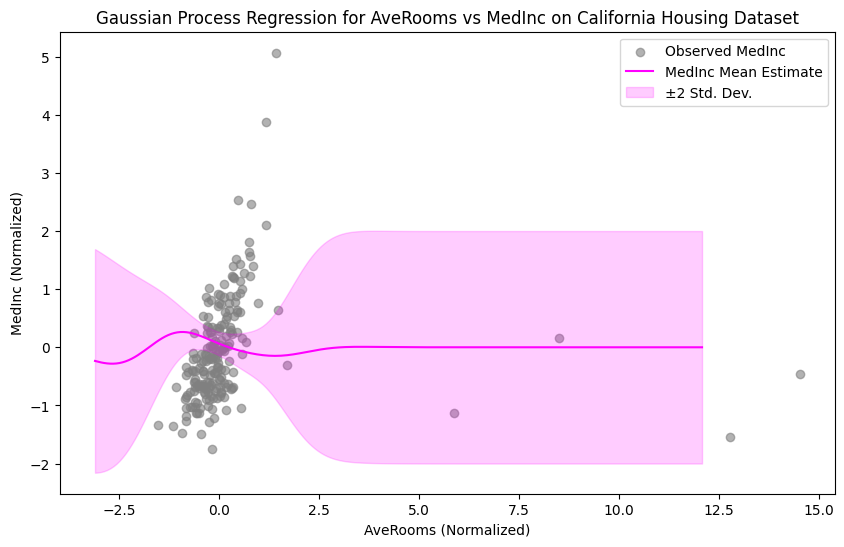

In [88]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label="Observed MedInc", alpha=0.6, color="gray")  # Original observations
plt.plot(X_new, mu, label="MedInc Mean Estimate", color="magenta")  # GP predictions
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, alpha=0.2, color="magenta", label="±2 Std. Dev.")
plt.title("Gaussian Process Regression for AveRooms vs MedInc on California Housing Dataset")
plt.xlabel("AveRooms (Normalized)")
plt.ylabel("MedInc (Normalized)")
plt.legend()
plt.show()

## Question 3

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.

Resource used: https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html


Using the sklearn breast cancer dataset w binary outcome variable.

In [51]:
floatX = pytensor.config.floatX
RANDOM_SEED = 1234
rng = np.random.default_rng(RANDOM_SEED)

In [53]:
# breast cancer dataset
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X = cancer.data
Y = cancer.target

# normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

X = X.astype(floatX)
y = Y.astype(floatX)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

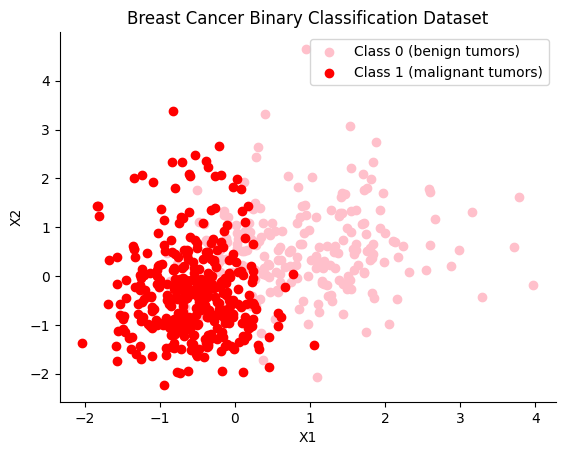

In [58]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color="pink", label="Class 0 (benign tumors)")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="red", label="Class 1 (malignant tumors)")
sns.despine()
ax.legend()
ax.set(xlabel="X1", ylabel="X2", title="Breast Cancer Binary Classification Dataset");

In [62]:
# resource used:
# https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html

def construct_bnn(batch_size=50):
    n_hidden = 5 # number hidden neurons

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        "obs_id": np.arange(X_train.shape[0]),
    }

    with pm.Model(coords=coords) as bnn_model_binary:

        # Define data variables using minibatches
        X_data = pm.Data("X_data", X_train, dims=("obs_id", "train_cols"))
        Y_data = pm.Data("Y_data", Y_train, dims="obs_id")

        # Define minibatch variables
        ann_input, ann_output = pm.Minibatch(X_data, Y_data, batch_size=batch_size)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=X_train.shape[0],  # IMPORTANT for minibatches
        )
    return bnn_model_binary


# Create the neural network model
bnn = construct_bnn()

In [63]:
%%time

with bnn:
    approx = pm.fit(n=30_000)

Output()

CPU times: user 30.6 s, sys: 704 ms, total: 31.4 s
Wall time: 1min 30s


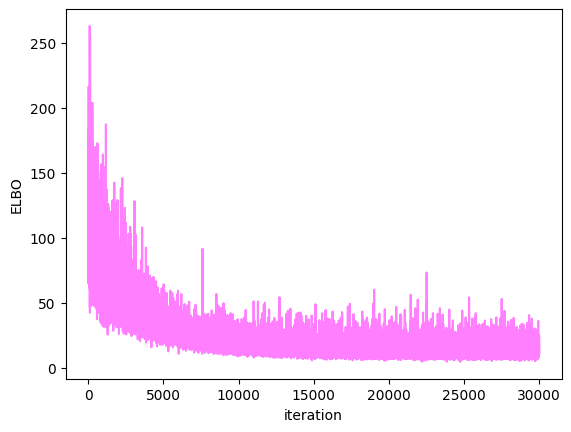

In [64]:
plt.plot(approx.hist, alpha=0.5, color="magenta")
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [66]:
bc_idata = approx.sample(draws=5000) # perform the sampling here

In [67]:
def sample_posterior_predictive(X_test, Y_test, idata, n_hidden=5):
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_test.shape[1]),
        "obs_id": np.arange(X_test.shape[0]),
    }
    with pm.Model(coords=coords):

        ann_input = X_test
        ann_output = Y_test

        weights_in_1 = pm.Flat("w_in_1", dims=("train_cols", "hidden_layer_1"))
        weights_1_2 = pm.Flat("w_1_2", dims=("hidden_layer_1", "hidden_layer_2"))
        weights_2_out = pm.Flat("w_2_out", dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli("out", act_out, observed=ann_output)
        return pm.sample_posterior_predictive(idata)


ppc = sample_posterior_predictive(X_test, Y_test, bc_idata)

Output()

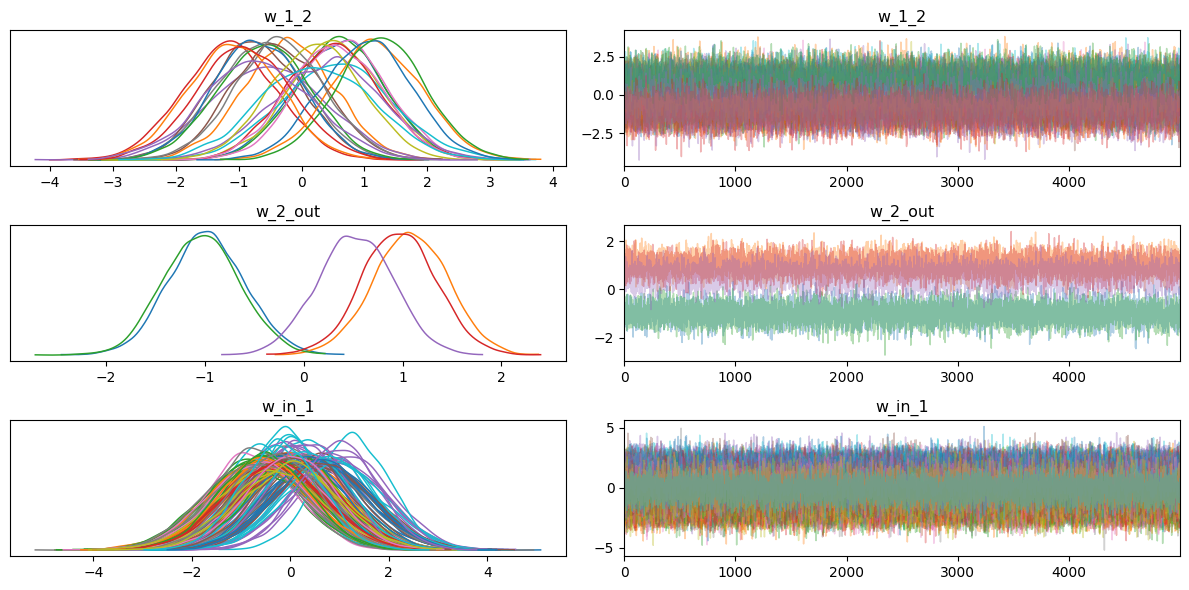

In [76]:
az.plot_trace(bc_idata)
plt.tight_layout()
plt.show()

In [68]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.5

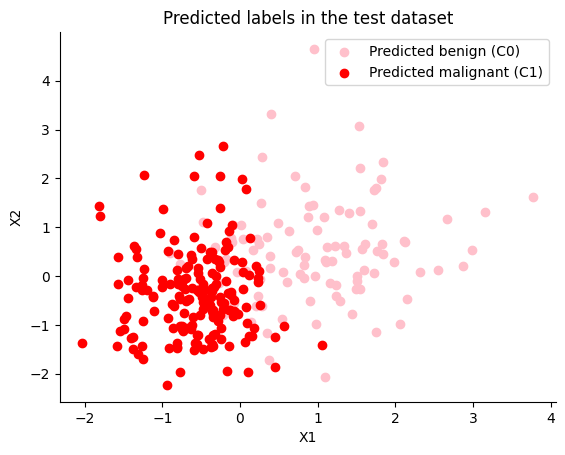

In [70]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="pink", label="Predicted benign (C0)")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="red", label="Predicted malignant (C1)")
sns.despine()
ax.legend()
ax.set(title="Predicted labels in the test dataset", xlabel="X1", ylabel="X2");

In [71]:
print(f"Accuracy = {(Y_test == pred.values).mean() * 100:.2f}%")

Accuracy = 97.89%


On a dataset with more than 2 classes, using softmax.
I did this for practice and to try working w different optimizers, learning rates, and PCA. Trying to bring together what i learened in this class, csc413, and sta414 together.

In [10]:
# dataset

# sklearn iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

# normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# make y a one-hot target vector
y = pd.get_dummies(y).to_numpy()

# do the training test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=365)

# define the Bayesian neural network
N = X_train.shape[0] # number of training examples
D = X_train.shape[1] # number of training features
K = y_train.shape[1] # number of classes

<Figure size 800x600 with 0 Axes>

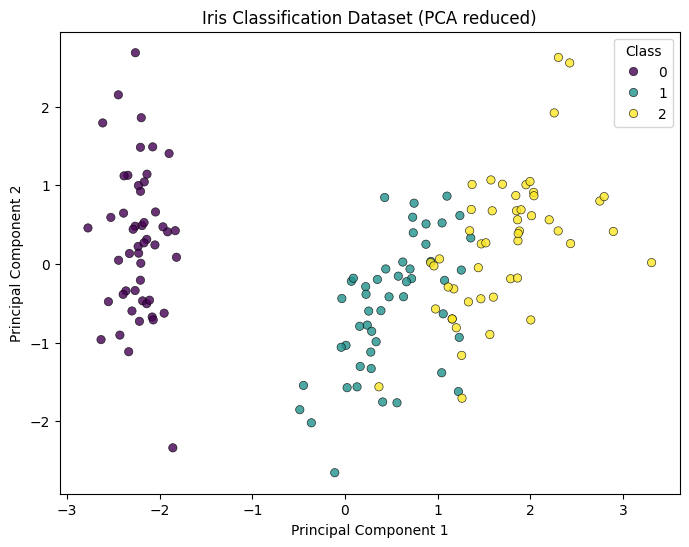

In [11]:
# plotting the features reduced by pca (I learned this in csc311 and sta414)
# use PCA to project onto 1st and 2nd principle components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df['Target'] = np.argmax(y, axis=1)

plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["PC1"], y=df["PC2"], hue=df["Target"], palette="viridis", alpha=0.8, edgecolor="k")
plt.title("Iris Classification Dataset (PCA reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class")
plt.show()

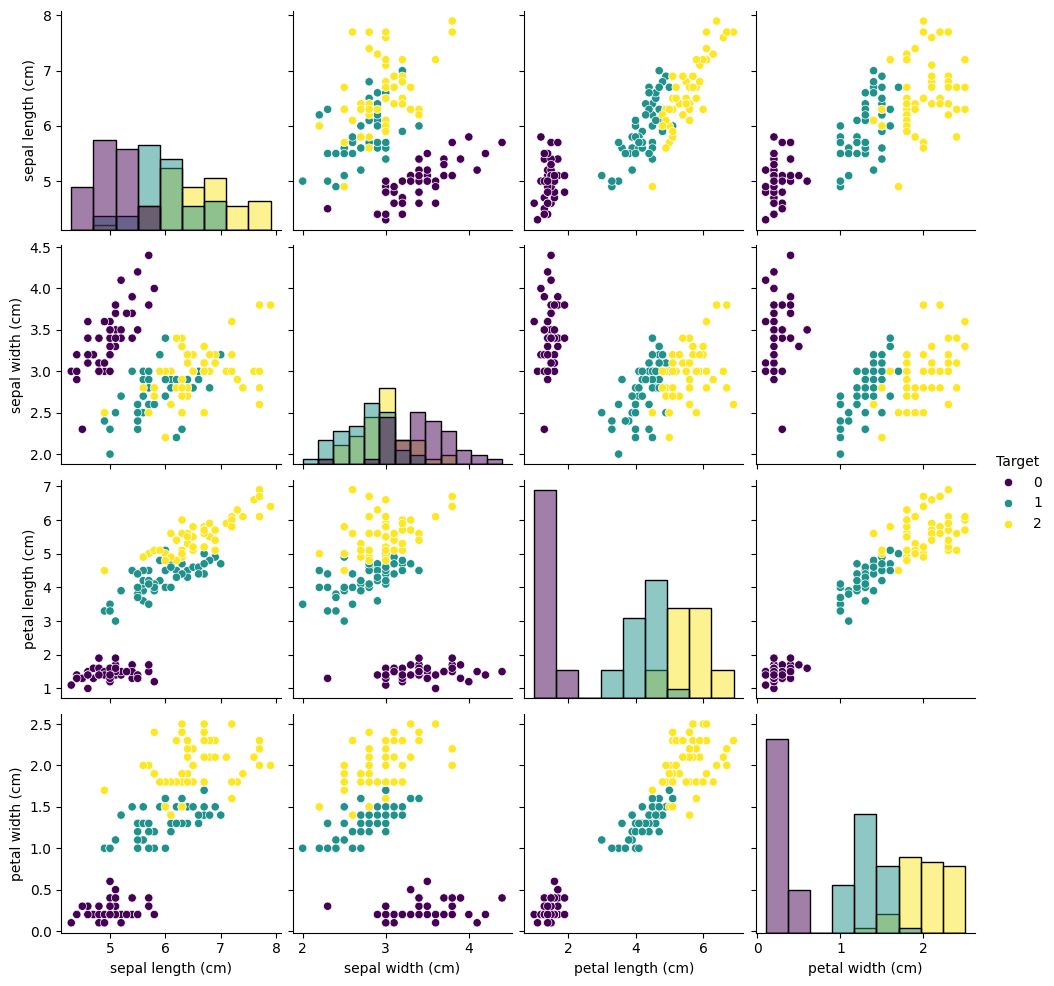

In [12]:
# original features pairplot
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["Target"] = iris.target

sns.pairplot(iris_df, hue="Target", palette="viridis", diag_kind="hist")
plt.show()

In [13]:
with pm.Model() as neural_network:
  # using 1 hidden layer w/ 10 neurons
  # weight and bias priors
  hidden_neurons = 10
  W_in = pm.Normal("W_in", mu=0, sigma=1, shape=(D, hidden_neurons))
  beta_in = pm.Normal("beta_in", mu=0, sigma=1, shape=(hidden_neurons,))
  z1 = pm.math.dot(X_train, W_in) + beta_in
  h1 = pm.math.tanh(z1) # 1st hidden layer
  W_out = pm.Normal('W_out', mu=0, sigma=1, shape=(hidden_neurons, K))
  beta_out = pm.Normal('beta_out', mu=0, sigma=1, shape=(K,))
  z2 = pm.math.dot(h1, W_out) + beta_out # the logits
  class_probs = pm.Deterministic('class_probs', pm.math.softmax(z2, axis=1))
  y_obs = pm.Categorical('y_obs', p=class_probs, observed=np.argmax(y_train, axis=1))
  # VI
  # vi_approx = pm.fit(n=5000, method=pm.ADVI()) # pymc.advi variational inference algorithm
  # ADAM optimizer and smaller learning rate to make ELBO (objective) improve iteratively
  vi_approx = pm.fit(n=10000, method=pm.ADVI(), obj_optimizer=pm.adam(learning_rate=0.005))
  idata_bnn = vi_approx.sample(draws=5000)

Output()

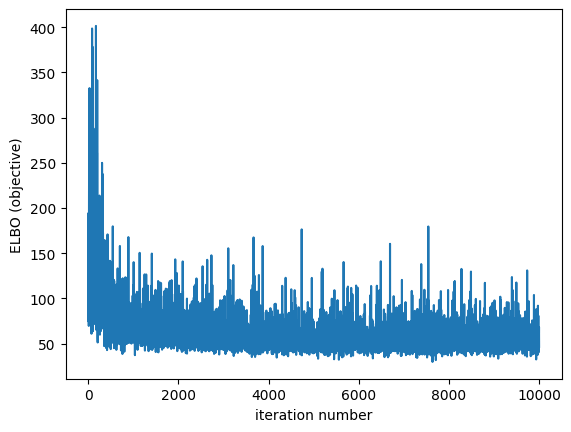

In [14]:
# plot the ELBO to see if/how optimization iteratively improves the fit
plt.plot(vi_approx.hist)
plt.xlabel("iteration number")
plt.ylabel("ELBO (objective)")
plt.show()

In [15]:
# plot posterior predictive
def sample_posterior_predictive(X_test, Y_test, idata, hidden_neurons=10):
    coords = {
        "hidden_layer": np.arange(hidden_neurons),
        "train_cols": np.arange(X_test.shape[1]),
        "obs_id": np.arange(X_test.shape[0]),
    }

    with pm.Model(coords=coords):

        ann_input = X_test
        ann_output = Y_test

        # priors
        W_in = pm.Normal("W_in", mu=0, sigma=1, shape=(X_test.shape[1], hidden_neurons))
        beta_in = pm.Normal("beta_in", mu=0, sigma=1, shape=(hidden_neurons,))

        W_out = pm.Normal("W_out", mu=0, sigma=1, shape=(hidden_neurons, Y_test.shape[1]))
        beta_out = pm.Normal("beta_out", mu=0, sigma=1, shape=(Y_test.shape[1],))

        # perform the forward pass
        z1 = pm.math.dot(ann_input, W_in) + beta_in
        h1 = pm.math.tanh(z1)

        z2 = pm.math.dot(h1, W_out) + beta_out
        class_probs = pm.Deterministic("class_probs", pm.math.softmax(z2, axis=1))

        # categorical likelihood
        out = pm.Categorical("out", p=class_probs, observed=np.argmax(ann_output, axis=1))

        return pm.sample_posterior_predictive(idata, var_names = ['class_probs'])

ppc_bnn = sample_posterior_predictive(X_test, y_test, idata_bnn, hidden_neurons=10)


Output()

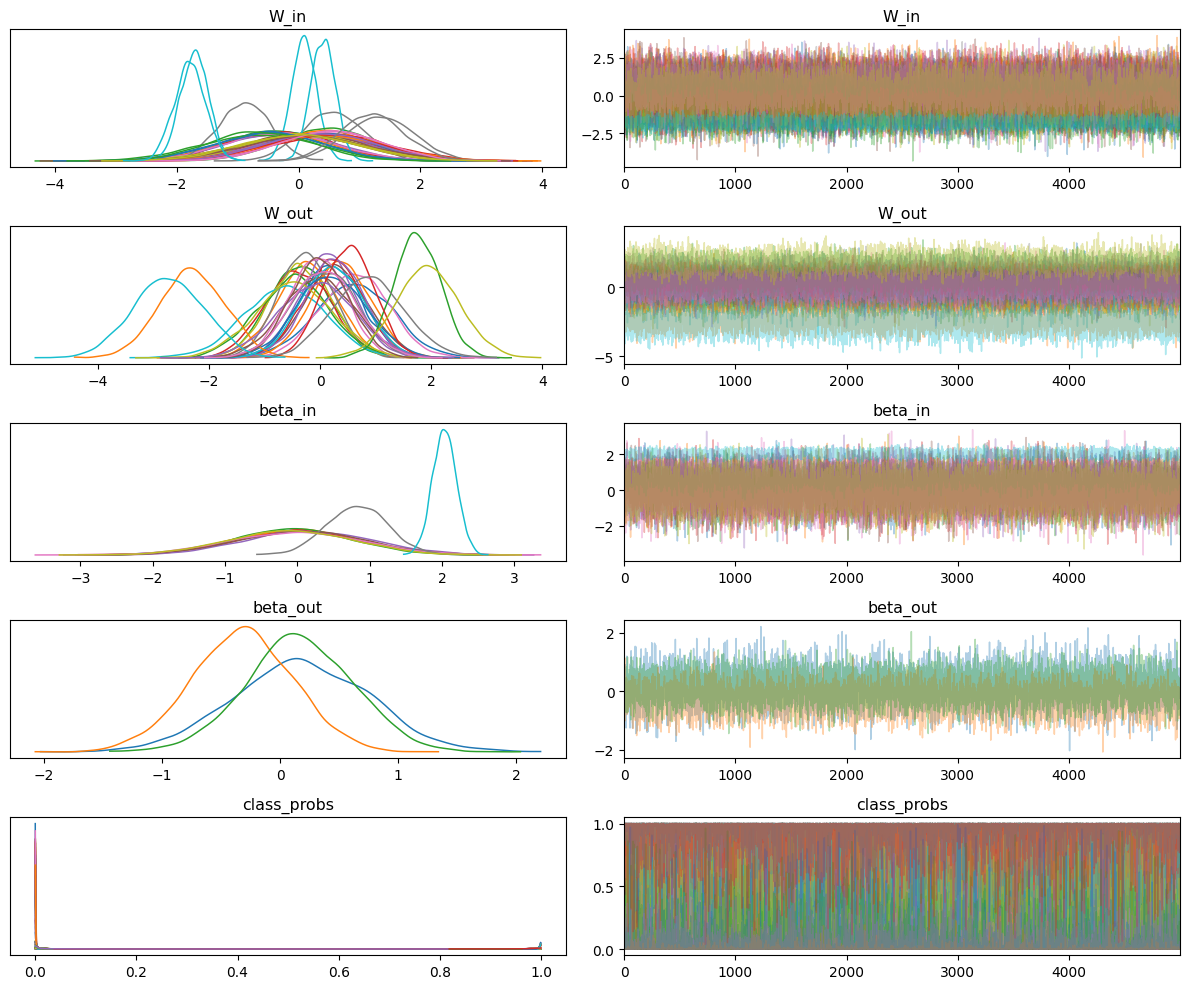

In [27]:
az.plot_trace(idata_bnn)
plt.tight_layout()
plt.show()

In [30]:
import numpy as np
import pymc as pm

def sample_posterior_predictive(X_test, Y_test, idata, hidden_neurons=10):
    coords = {
        "hidden_layer": np.arange(hidden_neurons),
        "train_cols": np.arange(X_test.shape[1]),
        "obs_id": np.arange(X_test.shape[0]),
    }

    with pm.Model(coords=coords):

        ann_input = X_test
        ann_output = Y_test

        # Priors for the model weights and biases
        W_in = pm.Normal("W_in", mu=0, sigma=1, shape=(X_test.shape[1], hidden_neurons))
        beta_in = pm.Normal("beta_in", mu=0, sigma=1, shape=(hidden_neurons,))

        W_out = pm.Normal("W_out", mu=0, sigma=1, shape=(hidden_neurons, Y_test.shape[1]))
        beta_out = pm.Normal("beta_out", mu=0, sigma=1, shape=(Y_test.shape[1],))

        # Forward pass computation
        z1 = pm.math.dot(ann_input, W_in) + beta_in
        h1 = pm.math.tanh(z1)

        z2 = pm.math.dot(h1, W_out) + beta_out
        class_probs = pm.Deterministic("class_probs", pm.math.softmax(z2, axis=1))

        # Categorical likelihood for observed data
        out = pm.Categorical("out", p=class_probs, observed=np.argmax(ann_output, axis=1))

        # Sample the posterior predictive distribution
        posterior_predictive = pm.sample_posterior_predictive(idata, var_names=["class_probs", "out"])

    return posterior_predictive

# Example usage
ppc_bnn = sample_posterior_predictive(X_test, y_test, idata_bnn, hidden_neurons=10)


Output()

In [74]:
# Assuming 'ppc.posterior_predictive["out"]' gives the posterior predictive probabilities for each class
class_probs = ppc_bnn.posterior_predictive["out"].mean(("chain", "draw"))

# Predicted class for each observation: find the class with the highest probability
pred_class = class_probs.argmax(axis=-1)